# Navigating by Falling Stars: Monetary Policy with Fiscally Driven Natural Rates
## Transition to the new steady state in under different assumptions of fiscal behavior

This notebook does the following:
1. It computes the transition to the new steady state when the tax rate and transfers adjust to replicate the bond issuance in the baseline case.
2. It saves the impulse response functions for these cases in `irfs/irf_transfer.json` and `irfs/irf_tax_rate.json`.
3. It produces Figure 4 in the paper.
4. It produces the following figure that appears in Appendix G.2:
   - Figure 11: additional variables

### Requirements
The code requires that the files `irfs/irf_baseline.json`, `ss/ss_hank_ini.json` and `ss/ss_hank_end.json` exist. It imports two versions of the model from the file `model.py` and various functions from `utils.py`. The code is othwerwise self-contained.

In [1]:
# Standard imports
import json
import os
import numpy as np

# Other imports
import sequence_jacobian as sj

from model import hank_tr, hank_tx
from utils import rebase_irf, plot_irfs, plot_residuals, is_residual

## Transition when transfers adjust 

In [2]:
print("\n")
print("=" *80)
print(f"The {hank_tr.name} model")
print("=" *80)
print(*hank_tr.blocks, sep='\n')

# Print out inputs and outputs of the HANK model
print(f"The {hank_tr.name} has inputs{hank_tr.inputs}")
print("-" * 80)
print(f"The {hank_tr.name} has outputs {hank_tr.outputs}")



The Two-Asset HANK with residual transfers model
<SolvedBlock 'labor_to_investment_combined_solved'>
<SolvedBlock 'pricing_solved'>
<SolvedBlock 'taylor_smooth'>
<SolvedBlock 'q_lb'>
<SimpleBlock 'rpost_lb'>
<SimpleBlock 'wage'>
<SimpleBlock 'dividend'>
<SimpleBlock 'residual_transfer'>
<SolvedBlock 'arbitrage_solved'>
<SimpleBlock 'finance'>
<HetBlock 'hh' with hetinput 'make_grids_marginal_cost_grid' and with hetoutput `adjustment_costs'>
<SimpleBlock 'union'>
<SimpleBlock 'mkt_clearing'>
The Two-Asset HANK with residual transfers has inputs['beta', 'eis', 'rb', 'chi0', 'chi1', 'chi2', 'chi3', 'tax', 'w', 'bmax', 'amax', 'kmax', 'nB', 'nA', 'nK', 'nZ', 'rho_z', 'sigma_z', 'Y', 'Z', 'alpha', 'ra_e', 'delta', 'epsI', 'kappap', 'mup', 'pi_ss', 'tau_d', 'Bg_Q_lb', 'Bgbar', 'G', 'kappaw', 'muw', 'vphi', 'frisch', 'rbar', 'phi', 'pibar', 'rho_i', 'delta_lb']
--------------------------------------------------------------------------------
The Two-Asset HANK with residual transfers has out

In [3]:
data = json.load(open(os.path.join("ss", "ss_hank_ini.json")))
additional_parameters = {
    'Bg_Q_lb': data["Bg"] / data["Q_lb"] 
}

data_with_additional = {**data, **additional_parameters}
ss_hank_ini = hank_tr.steady_state(data_with_additional, dissolve=[
    'taylor_smooth',
])

print("-" * 80)
print("Initial SS")
print(f"Asset market clearing: {ss_hank_ini['asset_mkt']: 0.2e}")
print(f"Bond market clearing: {ss_hank_ini['bond_mkt']: 0.2e}")
print(f"Goods market clearing (untargeted): {ss_hank_ini['goods_mkt']: 0.2e}")

print("-" * 80)
print("Full residual check")
for k, v in ss_hank_ini.toplevel.items():
    if is_residual(k):
        print(f"{k}: {v:.6f}")

--------------------------------------------------------------------------------
Initial SS
Asset market clearing:  2.36e-06
Bond market clearing: -2.24e-08
Goods market clearing (untargeted):  6.48e-08
--------------------------------------------------------------------------------
Full residual check
inv_res: 0.000000
val_res: 0.000000
nkpc_res: 0.000000
i_res: -0.000000
q_lb_res: 0.000000
rpost_res: 0.000000
B_res: 0.000000
equity_res: 0.000000
wnkpc_res: 0.000000
asset_mkt: 0.000002
bond_mkt: -0.000000
goods_mkt: 0.000000


In [4]:
data = json.load(open(os.path.join("ss", "ss_hank_end.json")))
additional_parameters = {
    'Bg_Q_lb': data["Bg"] / data["Q_lb"] 
}

data_with_additional = {**data, **additional_parameters}
ss_hank_end = hank_tr.steady_state(data_with_additional, dissolve=[
    'taylor_smooth',
])

print("-" * 80)
print("Final SS")
print(f"Asset market clearing: {ss_hank_end['asset_mkt']: 0.2e}")
print(f"Bond market clearing: {ss_hank_end['bond_mkt']: 0.2e}")
print(f"Goods market clearing (untargeted): {ss_hank_end['goods_mkt']: 0.2e}")

print("-" * 80)
print("Full residual check")
for k, v in ss_hank_end.toplevel.items():
    if is_residual(k):
        print(f"{k}: {v:.6f}")


--------------------------------------------------------------------------------
Final SS
Asset market clearing: -5.31e-08
Bond market clearing:  4.97e-08
Goods market clearing (untargeted):  4.52e-08
--------------------------------------------------------------------------------
Full residual check
inv_res: 0.000000
val_res: -0.000000
nkpc_res: 0.000000
i_res: -0.000000
q_lb_res: 0.000000
rpost_res: 0.000000
B_res: 0.000000
equity_res: -0.000000
wnkpc_res: -0.000000
asset_mkt: -0.000000
bond_mkt: 0.000000
goods_mkt: 0.000000


In [5]:
# Load baseline IRF
irf_baseline = json.load(open(os.path.join("irfs", "irf_baseline.json")))

T = len(irf_baseline['Bg_Q_lb'])

drbar = (ss_hank_end['rbar'] - ss_hank_ini['rbar']) * np.ones(T)
dG    = (ss_hank_end['G'] - ss_hank_ini['G']) * np.ones(T)
dBg_Q_lb = np.array(irf_baseline['Bg_Q_lb'])

shocks = {'Bg_Q_lb': dBg_Q_lb, 'rbar': drbar,  'G': dG}

shocks_rebased = rebase_irf(ss_hank_ini, ss_hank_end, shocks)
exogenous = shocks_rebased

unknowns = ['Y', 'w', 'ra_e', 'rb']
targets = ['asset_mkt', 'wnkpc_res', 'rpost_res', 'bond_mkt']

hank_tr.solve_impulse_nonlinear_options['maxit'] = 100
hank_tr.solve_impulse_nonlinear_options['tol'] = 1e-9

irf_hank_tr_r =  hank_tr.solve_impulse_nonlinear(ss_hank_end, unknowns, targets, exogenous, ss_initial=ss_hank_ini)

Solving Two-Asset HANK with residual transfers for ['Y', 'w', 'ra_e', 'rb'] to hit ['asset_mkt', 'wnkpc_res', 'rpost_res', 'bond_mkt']
Solving labor_to_investment_combined for ['Q', 'K'] to hit ['inv_res', 'val_res']
On iteration 0
   max error for inv_res is 6.15E-02
   max error for val_res is 0.00E+00
On iteration 1
   max error for inv_res is 2.88E-04
   max error for val_res is 1.34E-06
On iteration 2
   max error for inv_res is 1.41E-06
   max error for val_res is 1.03E-08
On iteration 3
   max error for inv_res is 7.13E-09
   max error for val_res is 4.17E-11
On iteration 4
   max error for inv_res is 3.57E-11
   max error for val_res is 2.23E-13
Solving pricing_solved_inner for ['pi'] to hit ['nkpc_res']
On iteration 0
   max error for nkpc_res is 1.71E-04
On iteration 1
   max error for nkpc_res is 4.60E-07
On iteration 2
   max error for nkpc_res is 1.95E-09
On iteration 3
   max error for nkpc_res is 7.42E-12
Solving taylor_smooth_inner for ['i'] to hit ['i_res']
On iteratio

On iteration 4
   max error for asset_mkt is 2.52E-05
   max error for wnkpc_res is 2.20E-06
   max error for rpost_res is 5.49E-06
   max error for bond_mkt is 2.87E-05
Solving labor_to_investment_combined for ['Q', 'K'] to hit ['inv_res', 'val_res']
On iteration 0
   max error for inv_res is 6.15E-02
   max error for val_res is 1.37E-03
On iteration 1
   max error for inv_res is 2.95E-04
   max error for val_res is 1.67E-06
On iteration 2
   max error for inv_res is 1.41E-06
   max error for val_res is 3.74E-08
On iteration 3
   max error for inv_res is 6.97E-09
   max error for val_res is 8.40E-10
On iteration 4
   max error for inv_res is 3.42E-11
   max error for val_res is 1.89E-11
Solving pricing_solved_inner for ['pi'] to hit ['nkpc_res']
On iteration 0
   max error for nkpc_res is 5.50E-04
On iteration 1
   max error for nkpc_res is 7.84E-06
On iteration 2
   max error for nkpc_res is 2.79E-08
On iteration 3
   max error for nkpc_res is 8.26E-11
Solving taylor_smooth_inner for

On iteration 9
   max error for asset_mkt is 1.70E-09
   max error for wnkpc_res is 1.29E-10
   max error for rpost_res is 3.71E-10
   max error for bond_mkt is 1.68E-09
Solving labor_to_investment_combined for ['Q', 'K'] to hit ['inv_res', 'val_res']
On iteration 0
   max error for inv_res is 6.15E-02
   max error for val_res is 1.37E-03
On iteration 1
   max error for inv_res is 2.95E-04
   max error for val_res is 1.67E-06
On iteration 2
   max error for inv_res is 1.41E-06
   max error for val_res is 3.74E-08
On iteration 3
   max error for inv_res is 6.97E-09
   max error for val_res is 8.40E-10
On iteration 4
   max error for inv_res is 3.41E-11
   max error for val_res is 1.89E-11
Solving pricing_solved_inner for ['pi'] to hit ['nkpc_res']
On iteration 0
   max error for nkpc_res is 5.50E-04
On iteration 1
   max error for nkpc_res is 7.83E-06
On iteration 2
   max error for nkpc_res is 2.78E-08
On iteration 3
   max error for nkpc_res is 8.24E-11
Solving taylor_smooth_inner for

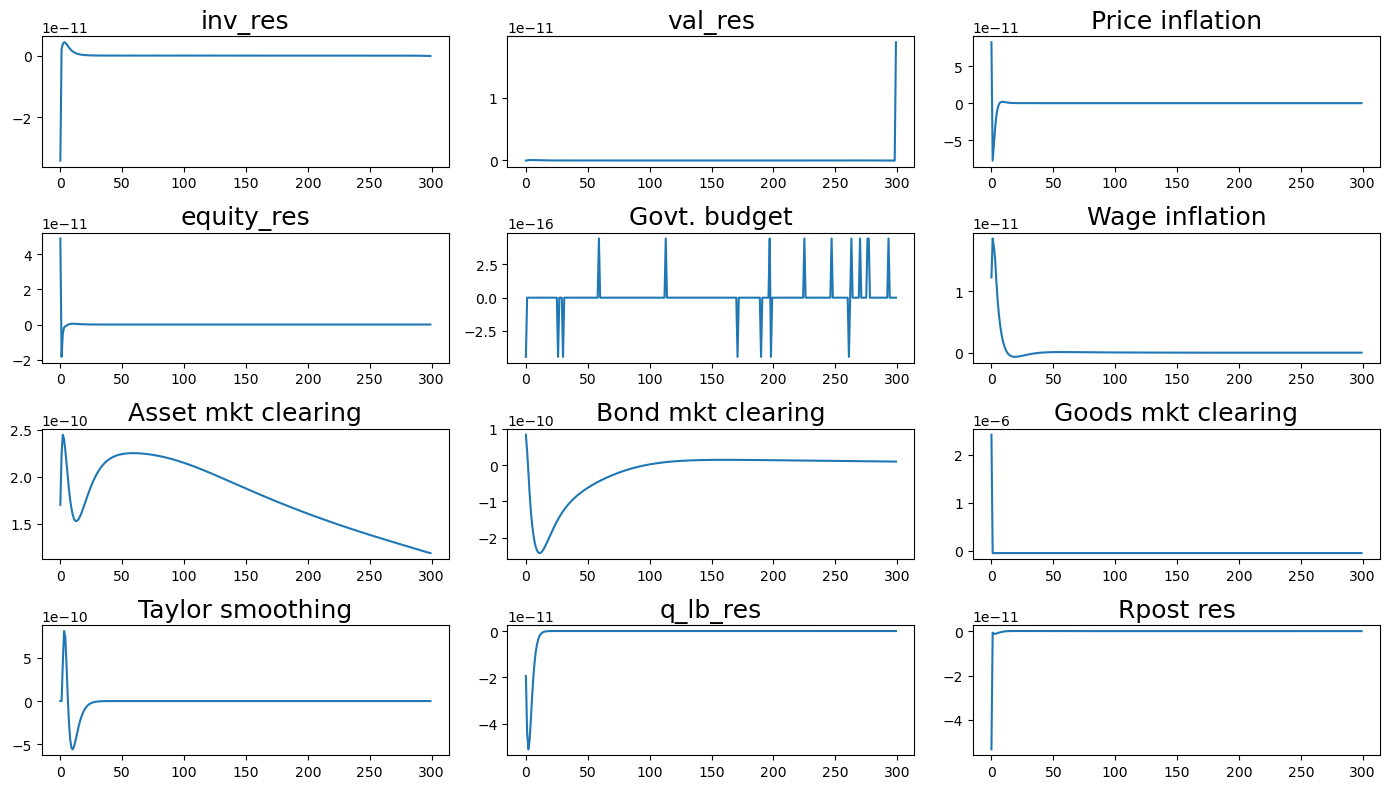

In [6]:
hank_tr_residuals = [k for k in hank_tr.outputs if is_residual(k)]
plot_residuals(irf_hank_tr_r, hank_tr_residuals)

In [7]:
irf_hank_tr = rebase_irf(ss_hank_end, ss_hank_ini, irf_hank_tr_r)

# Save to JSON
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

json.dump(irf_hank_tr, open(os.path.join("irfs", "irf_transfer.json"), 'w'), cls=NumpyEncoder, indent=4)

## Transition when the labor tax rate adjusts

In [8]:
print("\n")
print("=" *80)
print(f"The {hank_tx.name} model")
print("=" *80)
print(*hank_tx.blocks, sep='\n')

# Print out inputs and outputs of the HANK model
print(f"The {hank_tx.name} has inputs {hank_tx.inputs}")
print("-" * 80)
print(f"The {hank_tx.name} has outputs {hank_tx.outputs}")




The Two-Asset HANK with residual tax rate model
<SolvedBlock 'labor_to_investment_combined_solved'>
<SolvedBlock 'pricing_solved'>
<SolvedBlock 'taylor_smooth'>
<SolvedBlock 'q_lb'>
<SimpleBlock 'rpost_lb'>
<SimpleBlock 'wage'>
<SimpleBlock 'dividend'>
<SimpleBlock 'residual_tax'>
<SolvedBlock 'arbitrage_solved'>
<SimpleBlock 'finance'>
<HetBlock 'hh' with hetinput 'make_grids_marginal_cost_grid' and with hetoutput `adjustment_costs'>
<SimpleBlock 'union'>
<SimpleBlock 'mkt_clearing'>
The Two-Asset HANK with residual tax rate has inputs ['beta', 'eis', 'rb', 'chi0', 'chi1', 'chi2', 'chi3', 'w', 'Transfer', 'bmax', 'amax', 'kmax', 'nB', 'nA', 'nK', 'nZ', 'rho_z', 'sigma_z', 'Y', 'Z', 'alpha', 'ra_e', 'delta', 'epsI', 'kappap', 'mup', 'pi_ss', 'tau_d', 'Bgbar', 'G', 'Bg_Q_lb', 'kappaw', 'muw', 'vphi', 'frisch', 'rbar', 'phi', 'pibar', 'rho_i', 'delta_lb']
--------------------------------------------------------------------------------
The Two-Asset HANK with residual tax rate has outpu

In [9]:
data = json.load(open(os.path.join("ss", "ss_hank_ini.json")))
additional_parameters = {
    'Bg_Q_lb': data["Bg"] / data["Q_lb"] 
}

data_with_additional = {**data, **additional_parameters}
ss_hank_ini = hank_tx.steady_state(data_with_additional, dissolve=[
    'taylor_smooth',
])

print("-" * 80)
print("Initial SS")
print(f"Asset market clearing: {ss_hank_ini['asset_mkt']: 0.2e}")
print(f"Bond market clearing: {ss_hank_ini['bond_mkt']: 0.2e}")
print(f"Goods market clearing (untargeted): {ss_hank_ini['goods_mkt']: 0.2e}")

print("-" * 80)
print("Full residual check")
for k, v in ss_hank_ini.toplevel.items():
    if is_residual(k):
        print(f"{k}: {v:.6f}")

--------------------------------------------------------------------------------
Initial SS
Asset market clearing:  2.36e-06
Bond market clearing: -2.24e-08
Goods market clearing (untargeted):  6.48e-08
--------------------------------------------------------------------------------
Full residual check
inv_res: 0.000000
val_res: 0.000000
nkpc_res: 0.000000
i_res: -0.000000
q_lb_res: 0.000000
rpost_res: 0.000000
B_res: -0.000000
equity_res: 0.000000
wnkpc_res: 0.000000
asset_mkt: 0.000002
bond_mkt: -0.000000
goods_mkt: 0.000000


In [10]:
data = json.load(open(os.path.join("ss", "ss_hank_end.json")))
additional_parameters = {
    'Bg_Q_lb': data["Bg"] / data["Q_lb"] 
}

data_with_additional = {**data, **additional_parameters}
ss_hank_end = hank_tx.steady_state(data_with_additional, dissolve=[
    'taylor_smooth',
])

print("-" * 80)
print("Final SS")
print(f"Asset market clearing: {ss_hank_end['asset_mkt']: 0.2e}")
print(f"Bond market clearing: {ss_hank_end['bond_mkt']: 0.2e}")
print(f"Goods market clearing (untargeted): {ss_hank_end['goods_mkt']: 0.2e}")

print("-" * 80)
print("Full residual check")
for k, v in ss_hank_end.toplevel.items():
    if is_residual(k):
        print(f"{k}: {v:.6f}")


--------------------------------------------------------------------------------
Final SS
Asset market clearing: -5.32e-08
Bond market clearing:  4.97e-08
Goods market clearing (untargeted):  4.52e-08
--------------------------------------------------------------------------------
Full residual check
inv_res: 0.000000
val_res: -0.000000
nkpc_res: 0.000000
i_res: -0.000000
q_lb_res: 0.000000
rpost_res: 0.000000
B_res: 0.000000
equity_res: -0.000000
wnkpc_res: -0.000000
asset_mkt: -0.000000
bond_mkt: 0.000000
goods_mkt: 0.000000


In [11]:
# Load baseline IRF
irf_baseline = json.load(open(os.path.join("irfs", "irf_baseline.json")))

T = len(irf_baseline['Bg_Q_lb'])

drbar = (ss_hank_end['rbar'] - ss_hank_ini['rbar']) * np.ones(T)
dG    = (ss_hank_end['G'] - ss_hank_ini['G']) * np.ones(T)
dBg_Q_lb = np.array(irf_baseline['Bg_Q_lb'])


shocks = {'Bg_Q_lb': dBg_Q_lb, 'rbar': drbar,  'G': dG}

shocks_rebased = rebase_irf(ss_hank_ini, ss_hank_end, shocks)
exogenous = shocks_rebased

unknowns = ['Y', 'w', 'ra_e', 'rb']
targets = ['asset_mkt', 'wnkpc_res', 'rpost_res', 'bond_mkt']

hank_tx.solve_impulse_nonlinear_options['maxit'] = 100
hank_tx.solve_impulse_nonlinear_options['tol'] = 1e-9

irf_hank_tx_r =  hank_tx.solve_impulse_nonlinear(ss_hank_end, unknowns, targets, exogenous, ss_initial=ss_hank_ini)

Solving Two-Asset HANK with residual tax rate for ['Y', 'w', 'ra_e', 'rb'] to hit ['asset_mkt', 'wnkpc_res', 'rpost_res', 'bond_mkt']
Solving labor_to_investment_combined for ['Q', 'K'] to hit ['inv_res', 'val_res']
On iteration 0
   max error for inv_res is 6.15E-02
   max error for val_res is 0.00E+00
On iteration 1
   max error for inv_res is 2.88E-04
   max error for val_res is 1.34E-06
On iteration 2
   max error for inv_res is 1.41E-06
   max error for val_res is 1.03E-08
On iteration 3
   max error for inv_res is 7.13E-09
   max error for val_res is 4.17E-11
On iteration 4
   max error for inv_res is 3.57E-11
   max error for val_res is 2.23E-13
Solving pricing_solved_inner for ['pi'] to hit ['nkpc_res']
On iteration 0
   max error for nkpc_res is 1.71E-04
On iteration 1
   max error for nkpc_res is 4.60E-07
On iteration 2
   max error for nkpc_res is 1.95E-09
On iteration 3
   max error for nkpc_res is 7.42E-12
Solving taylor_smooth_inner for ['i'] to hit ['i_res']
On iteration

On iteration 4
   max error for asset_mkt is 5.03E-07
   max error for wnkpc_res is 2.74E-08
   max error for rpost_res is 3.61E-08
   max error for bond_mkt is 5.30E-07
Solving labor_to_investment_combined for ['Q', 'K'] to hit ['inv_res', 'val_res']
On iteration 0
   max error for inv_res is 6.15E-02
   max error for val_res is 3.60E-03
On iteration 1
   max error for inv_res is 3.12E-04
   max error for val_res is 1.13E-05
On iteration 2
   max error for inv_res is 1.30E-06
   max error for val_res is 1.75E-07
On iteration 3
   max error for inv_res is 1.05E-08
   max error for val_res is 1.06E-09
On iteration 4
   max error for inv_res is 1.56E-10
   max error for val_res is 2.66E-11
Solving pricing_solved_inner for ['pi'] to hit ['nkpc_res']
On iteration 0
   max error for nkpc_res is 1.89E-04
On iteration 1
   max error for nkpc_res is 5.04E-06
On iteration 2
   max error for nkpc_res is 2.14E-08
On iteration 3
   max error for nkpc_res is 7.81E-11
Solving taylor_smooth_inner for

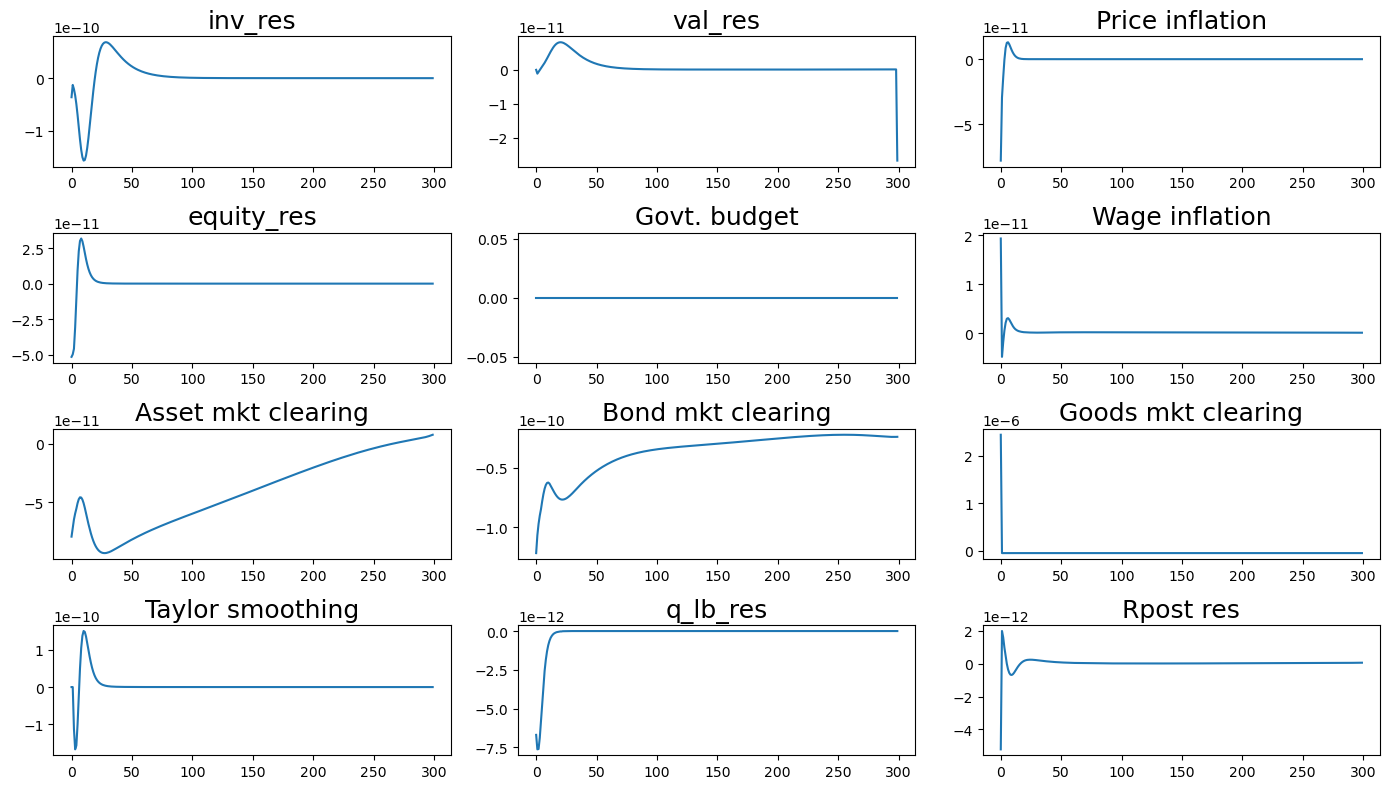

In [12]:
hank_tx_residuals = [k for k in hank_tx.outputs if is_residual(k)]
plot_residuals(irf_hank_tx_r, hank_tx_residuals)

In [13]:
irf_hank_tx = rebase_irf(ss_hank_end, ss_hank_ini, irf_hank_tx_r)

# Save to JSON
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
    
json.dump(irf_hank_tx, open(os.path.join("irfs", "irf_tax_rate.json"), 'w'), cls=NumpyEncoder, indent=4)

## Produce figure in the paper that shows different fiscal regimes

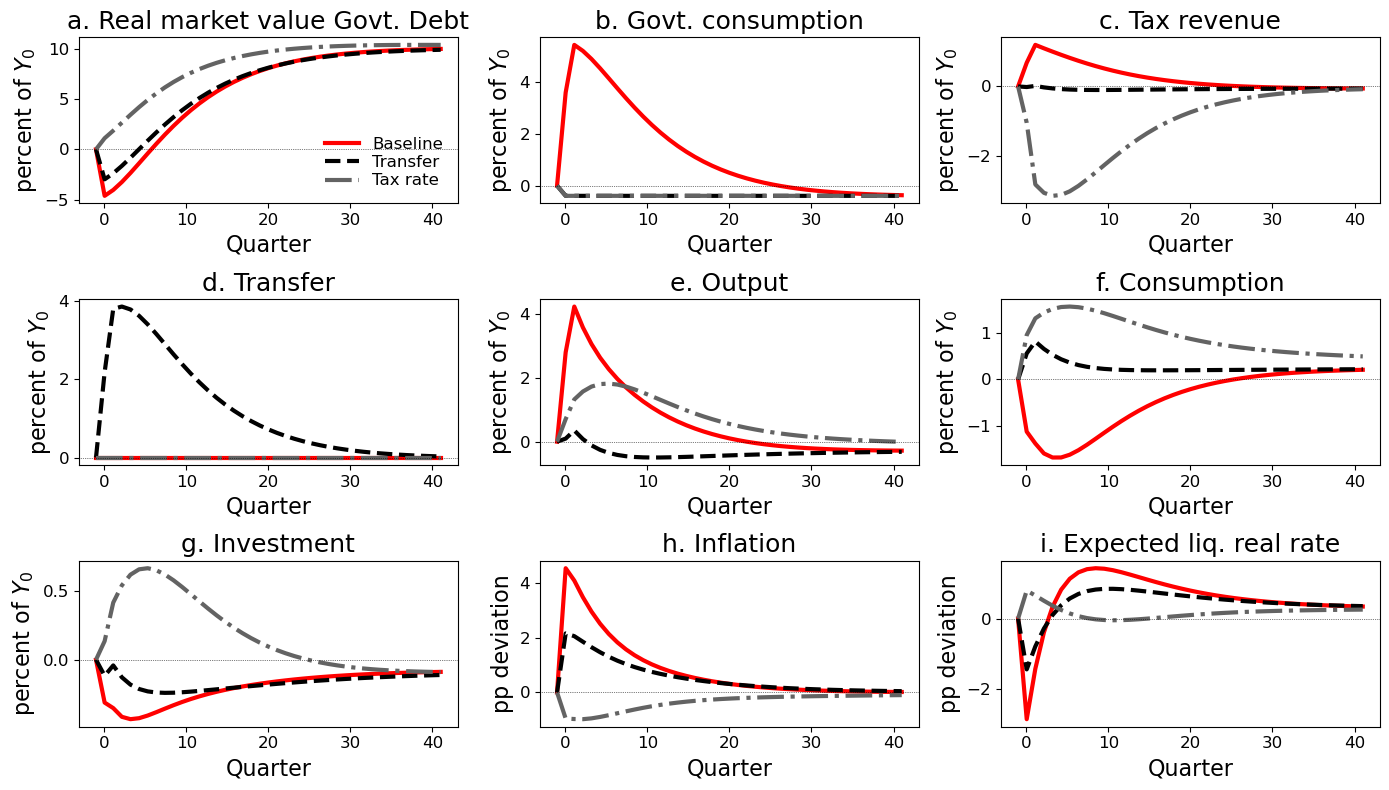

In [14]:
# Figure 4

irf_baseline = json.load(open(os.path.join("irfs", "irf_baseline.json")))
irf_baseline = {k: np.array(v) for (k, v) in irf_baseline.items()}

irf_transfer = json.load(open(os.path.join("irfs", "irf_transfer.json")))
irf_transfer = {k: np.array(v) for (k, v) in irf_transfer.items()}

irf_tax_rate = json.load(open(os.path.join("irfs", "irf_tax_rate.json")))
irf_tax_rate = {k: np.array(v) for (k, v) in irf_tax_rate.items()}

to_plot = {'Baseline': irf_baseline, 'Transfer': irf_transfer, 'Tax rate': irf_tax_rate}
plot_cases = ['Baseline', 'Transfer', 'Tax rate']
save_name = os.path.join("results", "fig_fiscal.pdf")
plot_irfs(to_plot, plot_cases, save_name=save_name, variables=['Bg', 'G', 'T', 'Transfer', 'Y', 'C', 'I', 'pi', 'rb_e'], ncols=3)


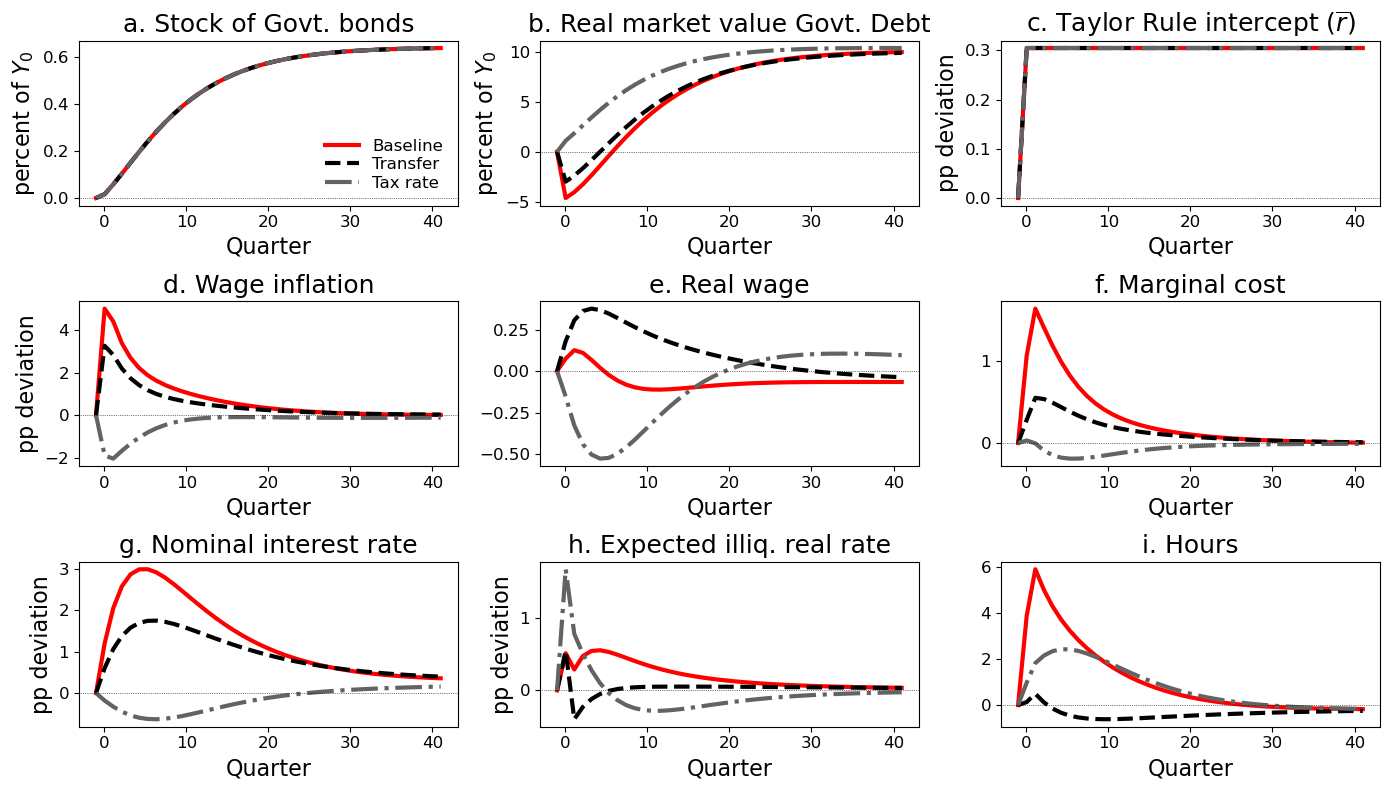

In [15]:
# Figure 11 in Appendix G.2

to_plot = {'Baseline': irf_baseline, 'Transfer': irf_transfer, 'Tax rate': irf_tax_rate}
plot_cases = ['Baseline', 'Transfer', 'Tax rate']
save_name = os.path.join("results", "fig_fiscal_infla.pdf")
plot_irfs(to_plot, plot_cases, save_name=save_name, variables=['Bg_Q_lb',  'Bg', 'rbar',  'piw', 'w', 'mc', 'i', 'ra_e', 'N'], ncols=3)